<a href="https://colab.research.google.com/github/tpiedrahita-byte/sys2025/blob/main/ACF_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Función de Autocorrelación y Modelo de Referencia

##  Definición de la Función de Autocorrelación

Sea $X[n]$ un proceso aleatorio discreto en el tiempo.  
La **función de autocorrelación teórica** se define como:

$$
R_X[k] \triangleq \mathbb{E}\{X[n]X^*[n+k]\}
$$

Si el proceso es **estacionario en sentido amplio (WSS)**, entonces:

- $\mathbb{E}\{X[n]\} = \mu$ es constante  
- $R_X[k]$ depende únicamente del desfase $k$

En tal caso,

$$
R_X[k] = \mathbb{E}\{X[n]X^*[n+k]\}
$$

es independiente del instante $n$.

La ACF cuantifica la dependencia estadística de segundo orden entre muestras separadas por un desfase $k$ y caracteriza completamente la estructura de correlación del proceso en el caso gaussiano.

---

## Modelo Teórico: Ruido Blanco Gaussiano

En este cuaderno se utilizará como señal de referencia un proceso de **ruido blanco gaussiano (WGN)** definido como:

$$
X[n] \sim \mathcal{N}(0,\sigma^2)
$$

con:

- Media cero: $\mathbb{E}\{X[n]\}=0$  
- Varianza constante: $\mathbb{E}\{X^2[n]\}=\sigma^2$  
- Independencia temporal

Su autocorrelación teórica es:

$$
R_X[k] = \sigma^2 \delta[k]
$$

donde $\delta[k]$ es el delta discreto:

$$
\delta[k] =
\begin{cases}
1, & k=0 \\
0, & k\neq 0
\end{cases}
$$

Esto implica que el proceso no presenta correlación para $k \neq 0$.

---

En las secciones siguientes se presentarán distintos métodos para estimar la función de autocorrelación a partir de una realización finita del proceso.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Gaussian noise definition
# -----------------------------
rng = np.random.default_rng(12345)

N = 4096            # number of samples
sigma = 1.0         # std dev
x = sigma * rng.standard_normal(N)  # real-valued white Gaussian noise

# Theoretical ACF for WGN: R[k] = sigma^2 * delta[k]
# so: R[0] = sigma^2, R[k!=0] = 0


## 1) Estimador Directo en el Dominio del Tiempo (Sesgado)

**Modelo / Estimador**
$$\hat{R}_b[k] \triangleq \frac{1}{N}S[k] = \frac{1}{N}\sum_{n=0}^{N-1-k} x[n]x^*[n+k], \quad k=0,\dots,N-1$$

**Esperanza (Sesgo) bajo WSS**
$$\mathbb{E}\{\hat{R}_b[k]\} = \left(1-\frac{k}{N}\right) R[k]$$

**Notas**
* El factor de sesgo $(1-k/N)$ se debe a la reducción de términos en desfases grandes.

* Preferido en DSP porque garantiza una matriz de correlación **definida positiva**.

---

## 1.2) Estimador Directo en el Dominio del Tiempo (Insesgado)

**Modelo / Estimador**
$$\hat{R}_u[k] \triangleq \frac{1}{N-k}S[k] = \frac{1}{N-k}\sum_{n=0}^{N-1-k} x[n]x^*[n+k], \quad k=0,\dots,N-1$$

**Esperanza bajo WSS**
$$\mathbb{E}\{\hat{R}_u[k]\} = R[k]$$

**Notas**
* Insesgado, pero con mayor varianza para $k$ grandes (menos datos promediados).
* Puede no producir una secuencia definida positiva.

---

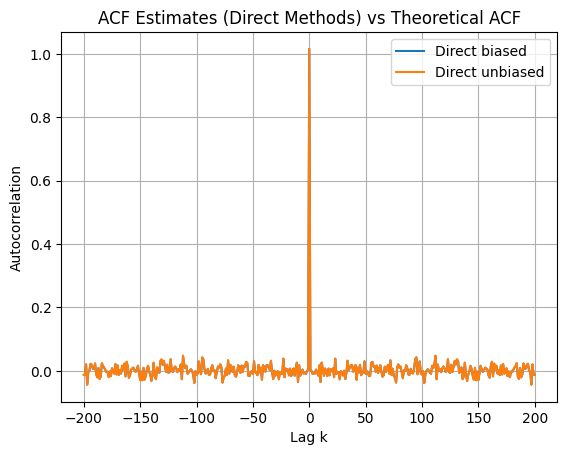

In [2]:
# -------------------------------------------------------
# 1) Direct ACF estimation (biased and unbiased)
#    We compute ACF for lags k = -L,...,0,...,+L
# -------------------------------------------------------
L = 200  # max lag to display (choose smaller to see detail)

# Compute positive-lag raw sums S[k] = sum_{n=0}^{N-1-k} x[n] x[n+k]
# We'll do this in a simple loop for clarity (L is small, so it's fast).
S = np.empty(L + 1, dtype=float)

for k in range(L + 1):
    S[k] = np.dot(x[:N - k], x[k:])  # dot product = sum(x[n]*x[n+k])

# Biased estimator: divide by N
R_b_pos = S / N

# Unbiased estimator: divide by (N-k)
R_u_pos = S / (N - np.arange(L + 1))

# Build full lag sequences using symmetry (real signal => even ACF approximately)
lags = np.arange(-L, L + 1)

# For real signals: R[-k] = R[+k]
R_b = np.concatenate((R_b_pos[:0:-1], R_b_pos))
R_u = np.concatenate((R_u_pos[:0:-1], R_u_pos))

# Theoretical ACF on this lag window
R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

# -----------------------------
# Plot (continuous, not stem)
# -----------------------------
plt.figure()
plt.plot(lags, R_b, label="Direct biased")
plt.plot(lags, R_u, label="Direct unbiased")
#plt.plot(lags, R_theory, label="Theoretical (WGN)")
plt.title("ACF Estimates (Direct Methods) vs Theoretical ACF")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()


## Estimación de la ACF mediante FFT (con zero-padding)

Sea una realización finita $x[0],\dots,x[N-1]$.  
La suma de autocorrelación aperiódica es:

$$
S[k] = \sum_{n=0}^{N-1-k} x[n]x^*[n+k]
$$

y el estimador sesgado:

$$
\hat R_b[k] = \frac{1}{N} S[k].
$$

---

### Método basado en FFT

Para calcular $S[k]$ eficientemente:

1. Elegir $M \ge 2N$ (para evitar correlación circular).
2. Construir $x_M[n]$ extendiendo con ceros hasta longitud $M$.
3. Calcular la DFT:

$$
X[m] = \mathrm{FFT}\{x_M[n]\}
$$

4. Formar el espectro de potencia discreto:

$$
|X[m]|^2 = X[m]X^*[m]
$$

5. Aplicar IFFT:

$$
r[k] = \mathrm{IFFT}\{|X[m]|^2\}
$$

Si $M \ge 2N$, entonces:

$$
r[k] = S[k], \quad k=0,\dots,N-1.
$$

Por tanto, el estimador FFT sesgado es:

$$
\hat R_{\text{FFT},b}[k] = \frac{1}{N} r[k].
$$

---




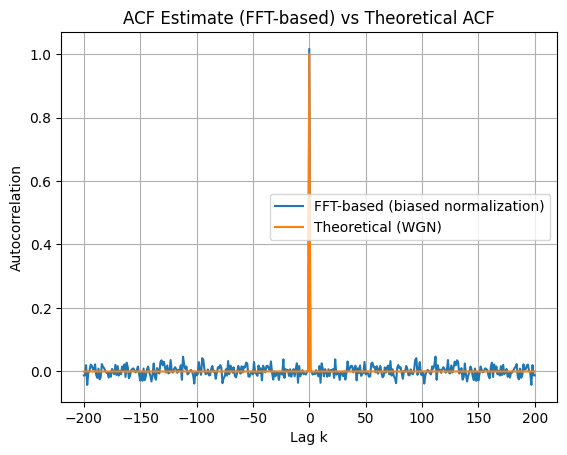

In [3]:
# -------------------------------------------------------
# 2) FFT-based ACF estimation (aperiodic via zero-padding)
# -------------------------------------------------------
# Choose M >= 2N to avoid circular correlation wrap-around.
M = 1 << int(np.ceil(np.log2(2 * N)))  # next power of 2 >= 2N

# Zero-pad x to length M
x_pad = np.zeros(M, dtype=float)
x_pad[:N] = x

# FFT -> power spectrum -> IFFT
X = np.fft.fft(x_pad)
r_circ = np.fft.ifft(np.abs(X)**2).real  # should be real for real x

# r_circ[0:L] corresponds to lags 0..L (aperiodic part due to padding)
S_fft = r_circ[:L + 1]  # raw sums S[k] (same idea as direct dot products)

# Normalize to match biased estimator (divide by N)
R_fft_biased_pos = S_fft / N

# Build full lags using symmetry
R_fft_biased = np.concatenate((R_fft_biased_pos[:0:-1], R_fft_biased_pos))

# Theoretical ACF on this lag window
R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

# -----------------------------
# Plot (continuous, not stem)
# -----------------------------
plt.figure()
plt.plot(lags, R_fft_biased, label="FFT-based (biased normalization)")
plt.plot(lags, R_theory, label="Theoretical (WGN)")
plt.title("ACF Estimate (FFT-based) vs Theoretical ACF")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()


## Estimación Paramétrica de la ACF mediante AR(p) (Yule–Walker)

### Modelo AR(p)

Se asume que el proceso sigue un modelo autorregresivo de orden $p$:

$$
X[n] = \sum_{i=1}^{p} a_i X[n-i] + W[n]
$$

donde $W[n]$ es ruido blanco con varianza $\sigma_w^2$.

---

### Ecuaciones de Yule–Walker

Para un proceso WSS, la ACF satisface:

$$
R[k] = \sum_{i=1}^{p} a_i R[k-i], \quad k \ge 1
$$

y para $k=0$:

$$
R[0] = \sum_{i=1}^{p} a_i R[i] + \sigma_w^2
$$

En forma matricial (sistema Toeplitz):

$$
\underbrace{
\begin{bmatrix}
R[0] & R[1] & \cdots & R[p-1] \\
R[1] & R[0] & \cdots & R[p-2] \\
\vdots & \vdots & \ddots & \vdots \\
R[p-1] & R[p-2] & \cdots & R[0]
\end{bmatrix}
}_{T_p}
\begin{bmatrix}
a_1 \\
a_2 \\
\vdots \\
a_p
\end{bmatrix}
=
\begin{bmatrix}
R[1] \\
R[2] \\
\vdots \\
R[p]
\end{bmatrix}
$$

---

### Procedimiento de Estimación

1. Estimar $\hat R[0],\dots,\hat R[p]$ (usualmente con el estimador sesgado).
2. Resolver el sistema:

$$
\hat T_p \hat a = \hat r
$$

3. Estimar la varianza de innovación:

$$
\hat\sigma_w^2 = \hat R[0] - \sum_{i=1}^{p} \hat a_i \hat R[i]
$$

4. Generar la ACF paramétrica recursivamente:

$$
\hat R_{\text{AR}}[k] = \sum_{i=1}^{p} \hat a_i \hat R_{\text{AR}}[k-i], \quad k \ge 1
$$

---

### Características

- Produce una ACF suave y consistente con el modelo asumido.
- Reduce varianza respecto a métodos no paramétricos.
- Depende críticamente del orden $p$.


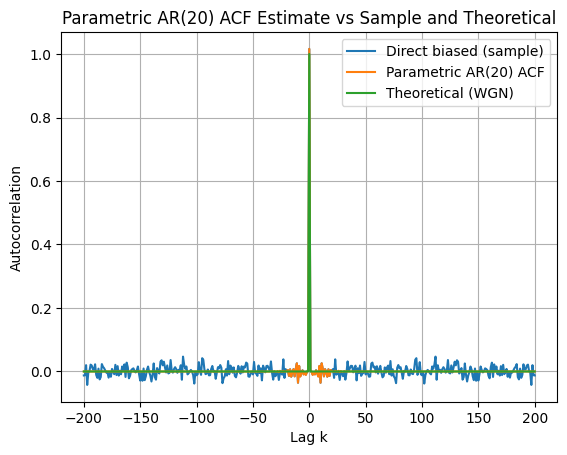

Estimated AR coefficients a_i:
[ 0.00582803 -0.00131633 -0.01068845 -0.00482722 -0.00946705  0.00359371
 -0.0043755  -0.01623524  0.01783745 -0.0358086   0.02528191  0.00742937
 -0.01634469  0.00793653 -0.00210942 -0.01587546  0.00714293 -0.01560309
  0.0066373  -0.00013932]
Estimated innovation variance sigma_w^2: 1.0123397592061227


In [4]:
# -------------------------------------------------------
# 4) Parametric ACF estimation via AR(p) (Yule–Walker)
# Uses the same x, N, sigma, L from previous blocks.
# If you're running this standalone, re-define x, N, sigma, L.
# -------------------------------------------------------

p = 20  # AR model order (try 5, 10, 20; for white noise, true is ~0)

# Step A: Estimate autocorrelation needed for Yule–Walker.
# Common choice: biased ACF estimates for Toeplitz PSD stability.
R0_to_p = np.empty(p + 1, dtype=float)
for k in range(p + 1):
    R0_to_p[k] = np.dot(x[:N - k], x[k:]) / N  # biased normalization

# Build Toeplitz matrix T_p from R[0..p-1]
# T[i,j] = R[|i-j|], i,j = 0..p-1
T = np.empty((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        T[i, j] = R0_to_p[abs(i - j)]

# Right-hand side vector r = [R[1],...,R[p]]
r = R0_to_p[1:p+1].copy()

# Step B: Solve Yule–Walker for AR coefficients a
# T a = r
# If T is near-singular, lstsq is more robust than solve.
a, *_ = np.linalg.lstsq(T, r, rcond=None)

# Step C: Estimate innovation variance sigma_w^2 (from k=0 equation)
sigma_w2 = R0_to_p[0] - np.dot(a, R0_to_p[1:p+1])

# Step D: Generate parametric ACF up to lag L using the AR recursion
R_ar_pos = np.zeros(L + 1, dtype=float)
R_ar_pos[0] = R0_to_p[0]  # anchor with estimated R[0]

# For k=1..L:
# R[k] = sum_{i=1..p} a_i R[k-i], using R[negative] = R[positive] symmetry
for k in range(1, L + 1):
    acc = 0.0
    for i in range(1, p + 1):
        idx = k - i
        if idx >= 0:
            acc += a[i - 1] * R_ar_pos[idx]
        else:
            # For a real WSS process: R[-m] = R[m]
            acc += a[i - 1] * R_ar_pos[-idx]
    R_ar_pos[k] = acc

# Build full lags via symmetry
lags = np.arange(-L, L + 1)
R_ar = np.concatenate((R_ar_pos[:0:-1], R_ar_pos))

# Theoretical ACF for WGN
R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

# Optional: also compare against the direct biased estimate in the same plot
# (recompute quickly for window L)
S = np.empty(L + 1, dtype=float)
for k in range(L + 1):
    S[k] = np.dot(x[:N - k], x[k:])
R_direct_b_pos = S / N
R_direct_b = np.concatenate((R_direct_b_pos[:0:-1], R_direct_b_pos))

# -----------------------------
# Plot (continuous)
# -----------------------------
plt.figure()
plt.plot(lags, R_direct_b, label="Direct biased (sample)")
plt.plot(lags, R_ar, label=f"Parametric AR({p}) ACF")
plt.plot(lags, R_theory, label="Theoretical (WGN)")
plt.title(f"Parametric AR({p}) ACF Estimate vs Sample and Theoretical")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()

# Print estimated AR coefficients magnitude (should be near 0 for WGN)
print("Estimated AR coefficients a_i:")
print(a)
print("Estimated innovation variance sigma_w^2:", sigma_w2)


## Estimación Recursiva de la ACF (EWMA / Forgetting Factor)

Sea una secuencia $x[n]$ observada en streaming.  
La autocorrelación teórica es:

$$
R[k] = \mathbb{E}\{X[n]X^*[n-k]\}
$$

Para estimarla en línea (online), se utiliza un promedio exponencialmente ponderado:

---

### Estimador Recursivo

Para cada desfase $k = 0,\dots,L$:

$$
\hat R_k[n]
=
\lambda \hat R_k[n-1]
+
(1-\lambda)\,x[n]x^*[n-k],
\qquad 0 < \lambda < 1
$$

donde:

- $\lambda$ es el **factor de olvido**
- $x[n]x^*[n-k]$ es la correlación instantánea

---

### Interpretación

El estimador implementa un filtro IIR de primer orden sobre el producto instantáneo.  
Equivale a un promedio ponderado:

$$
\hat R_k[n]
=
(1-\lambda)
\sum_{m=0}^{\infty}
\lambda^{m}
\,x[n-m]x^*[n-m-k]
$$

---

### Longitud efectiva de memoria

La ventana efectiva aproximada es:

$$
N_{\text{eff}} \approx \frac{1}{1-\lambda}
$$

- $\lambda \to 1$ → mayor suavizado, menor varianza  
- $\lambda$ pequeño → mayor adaptabilidad, mayor varianza  

---




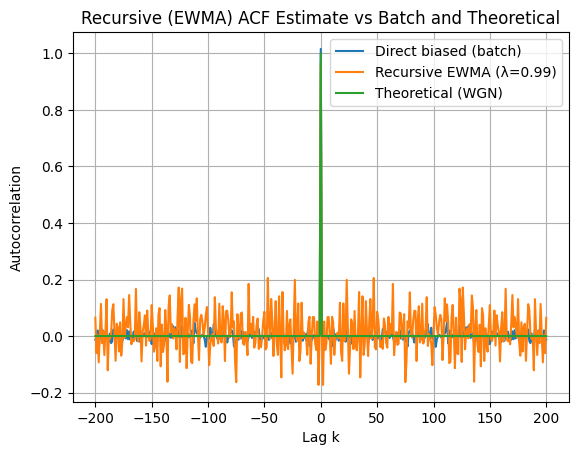

Effective averaging length ~ 100.0 samples
Recursive estimate R_rec_pos[0] (should be ~ sigma^2): 0.9666032540978791


In [5]:
# -------------------------------------------------------
# 5) Recursive ACF estimation (EWMA / forgetting factor)
# Uses the same x, N, sigma, L from previous blocks.
# If running standalone, re-define x, N, sigma, L.
# -------------------------------------------------------

L = 200          # max lag to estimate/display
lam = 0.99       # forgetting factor (0.95..0.999 typical)
# Effective window length ~ 1/(1-lam) = 100 samples for 0.99

# Initialize recursive estimates for lags 0..L
R_rec_pos = np.zeros(L + 1, dtype=float)

# Run recursive updates through the data stream
# Update only when n >= k (otherwise x[n-k] doesn't exist)
for n in range(N):
    xn = x[n]
    # lag 0 update
    R_rec_pos[0] = lam * R_rec_pos[0] + (1 - lam) * (xn * xn)

    # lags 1..L
    kmax = min(L, n)
    for k in range(1, kmax + 1):
        R_rec_pos[k] = lam * R_rec_pos[k] + (1 - lam) * (xn * x[n - k])

# Build full lags by symmetry (real WSS => R[-k]=R[k])
lags = np.arange(-L, L + 1)
R_rec = np.concatenate((R_rec_pos[:0:-1], R_rec_pos))

# Theoretical ACF for WGN
R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

# Optional: compare with direct biased estimator on the same lag window
S = np.empty(L + 1, dtype=float)
for k in range(L + 1):
    S[k] = np.dot(x[:N - k], x[k:])
R_direct_b_pos = S / N
R_direct_b = np.concatenate((R_direct_b_pos[:0:-1], R_direct_b_pos))

# -----------------------------
# Plot (continuous)
# -----------------------------
plt.figure()
plt.plot(lags, R_direct_b, label="Direct biased (batch)")
plt.plot(lags, R_rec, label=f"Recursive EWMA (λ={lam})")
plt.plot(lags, R_theory, label="Theoretical (WGN)")
plt.title("Recursive (EWMA) ACF Estimate vs Batch and Theoretical")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()

# Helpful diagnostic
Neff = 1.0 / (1.0 - lam)
print(f"Effective averaging length ~ {Neff:.1f} samples")
print("Recursive estimate R_rec_pos[0] (should be ~ sigma^2):", R_rec_pos[0])


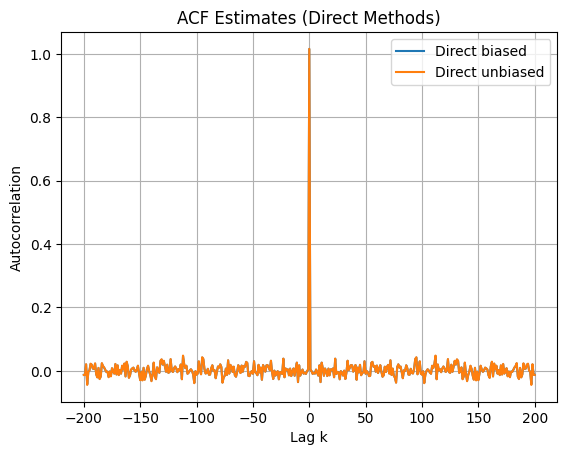

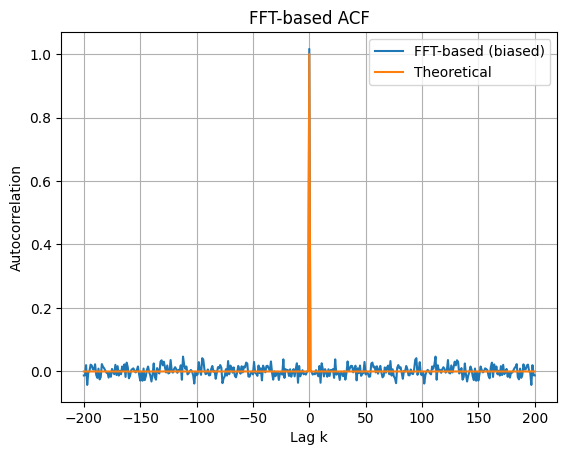

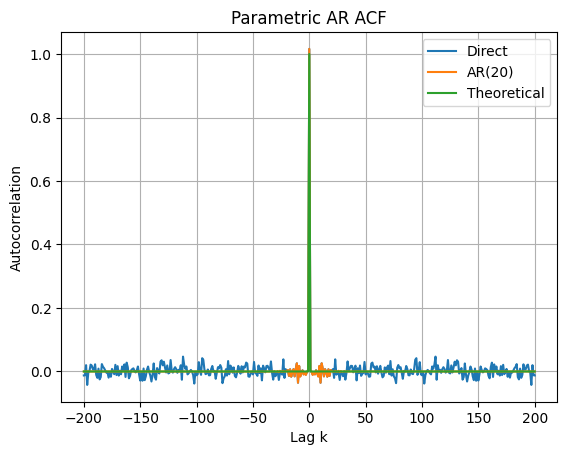

Estimated AR coefficients a_i:
[ 0.00582803 -0.00131633 -0.01068845 -0.00482722 -0.00946705  0.00359371
 -0.0043755  -0.01623524  0.01783745 -0.0358086   0.02528191  0.00742937
 -0.01634469  0.00793653 -0.00210942 -0.01587546  0.00714293 -0.01560309
  0.0066373  -0.00013932]
Estimated innovation variance sigma_w^2: 1.0123397592061227


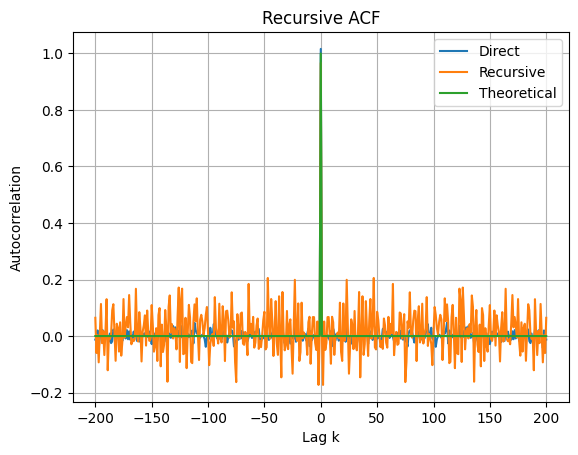

Effective averaging length ~ 100.0
Recursive estimate R_rec_pos[0]: 0.9666032540978791

Tiempo total de ejecución: 4.019397 segundos


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

# =============================
# TIMER START
# =============================
start_time = time.perf_counter()

# -----------------------------
# 1) Gaussian noise definition
# -----------------------------
rng = np.random.default_rng(12345)

N = 4096
sigma = 1.0
x = sigma * rng.standard_normal(N)

# -------------------------------------------------------
# 1) Direct ACF estimation
# -------------------------------------------------------
L = 200

S = np.empty(L + 1, dtype=float)

for k in range(L + 1):
    S[k] = np.dot(x[:N - k], x[k:])

R_b_pos = S / N
R_u_pos = S / (N - np.arange(L + 1))

lags = np.arange(-L, L + 1)

R_b = np.concatenate((R_b_pos[:0:-1], R_b_pos))
R_u = np.concatenate((R_u_pos[:0:-1], R_u_pos))

R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

plt.figure()
plt.plot(lags, R_b, label="Direct biased")
plt.plot(lags, R_u, label="Direct unbiased")
plt.title("ACF Estimates (Direct Methods)")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------
# 2) FFT-based ACF estimation
# -------------------------------------------------------
M = 1 << int(np.ceil(np.log2(2 * N)))

x_pad = np.zeros(M, dtype=float)
x_pad[:N] = x

X = np.fft.fft(x_pad)
r_circ = np.fft.ifft(np.abs(X)**2).real

S_fft = r_circ[:L + 1]
R_fft_biased_pos = S_fft / N
R_fft_biased = np.concatenate((R_fft_biased_pos[:0:-1], R_fft_biased_pos))

plt.figure()
plt.plot(lags, R_fft_biased, label="FFT-based (biased)")
plt.plot(lags, R_theory, label="Theoretical")
plt.title("FFT-based ACF")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------
# 4) Parametric ACF estimation via AR(p)
# -------------------------------------------------------
p = 20

R0_to_p = np.empty(p + 1, dtype=float)
for k in range(p + 1):
    R0_to_p[k] = np.dot(x[:N - k], x[k:]) / N

T = np.empty((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        T[i, j] = R0_to_p[abs(i - j)]

r = R0_to_p[1:p+1].copy()
a, *_ = np.linalg.lstsq(T, r, rcond=None)

sigma_w2 = R0_to_p[0] - np.dot(a, R0_to_p[1:p+1])

R_ar_pos = np.zeros(L + 1, dtype=float)
R_ar_pos[0] = R0_to_p[0]

for k in range(1, L + 1):
    acc = 0.0
    for i in range(1, p + 1):
        idx = k - i
        if idx >= 0:
            acc += a[i - 1] * R_ar_pos[idx]
        else:
            acc += a[i - 1] * R_ar_pos[-idx]
    R_ar_pos[k] = acc

R_ar = np.concatenate((R_ar_pos[:0:-1], R_ar_pos))

plt.figure()
plt.plot(lags, R_b, label="Direct")
plt.plot(lags, R_ar, label=f"AR({p})")
plt.plot(lags, R_theory, label="Theoretical")
plt.title("Parametric AR ACF")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()

print("Estimated AR coefficients a_i:")
print(a)
print("Estimated innovation variance sigma_w^2:", sigma_w2)

# -------------------------------------------------------
# 5) Recursive ACF estimation (EWMA)
# -------------------------------------------------------
lam = 0.99
R_rec_pos = np.zeros(L + 1, dtype=float)

for n in range(N):
    xn = x[n]
    R_rec_pos[0] = lam * R_rec_pos[0] + (1 - lam) * (xn * xn)
    kmax = min(L, n)
    for k in range(1, kmax + 1):
        R_rec_pos[k] = lam * R_rec_pos[k] + (1 - lam) * (xn * x[n - k])

R_rec = np.concatenate((R_rec_pos[:0:-1], R_rec_pos))

plt.figure()
plt.plot(lags, R_b, label="Direct")
plt.plot(lags, R_rec, label="Recursive")
plt.plot(lags, R_theory, label="Theoretical")
plt.title("Recursive ACF")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()

Neff = 1.0 / (1.0 - lam)
print(f"Effective averaging length ~ {Neff:.1f}")
print("Recursive estimate R_rec_pos[0]:", R_rec_pos[0])

# =============================
# TIMER END
# =============================
end_time = time.perf_counter()
execution_time = end_time - start_time

print(f"\nTiempo total de ejecución: {execution_time:.6f} segundos")

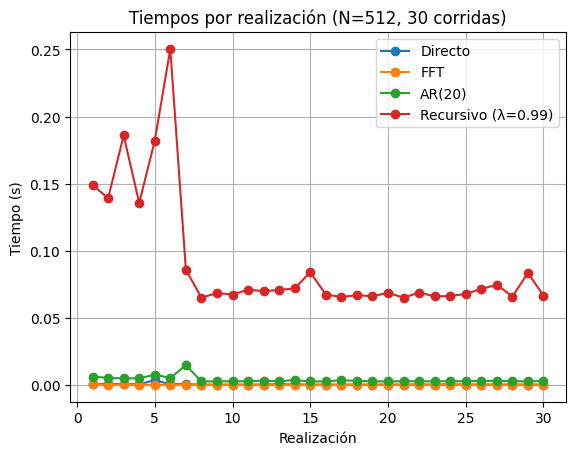


===== Resultados para N=512 =====
         Directo:  E[t]=6.353985e-04 s   std=5.908609e-04 s
             FFT:  E[t]=2.565644e-04 s   std=1.010185e-04 s
          AR(20):  E[t]=3.971268e-03 s   std=2.406431e-03 s
Recursivo(λ=0.99):  E[t]=9.098966e-02 s   std=4.603552e-02 s


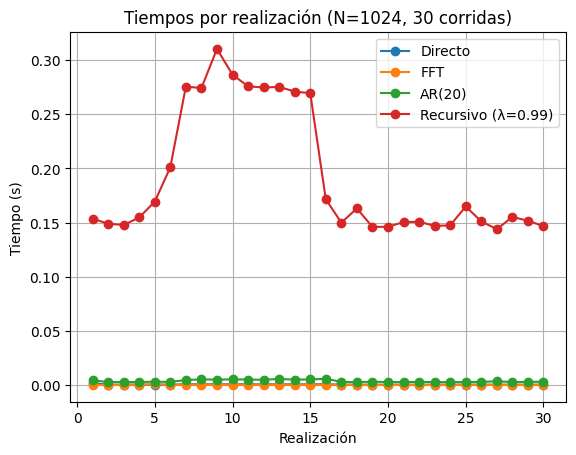


===== Resultados para N=1024 =====
         Directo:  E[t]=6.179985e-04 s   std=3.012493e-04 s
             FFT:  E[t]=3.264855e-04 s   std=1.387833e-04 s
          AR(20):  E[t]=3.806363e-03 s   std=1.128785e-03 s
Recursivo(λ=0.99):  E[t]=1.924370e-01 s   std=5.909846e-02 s


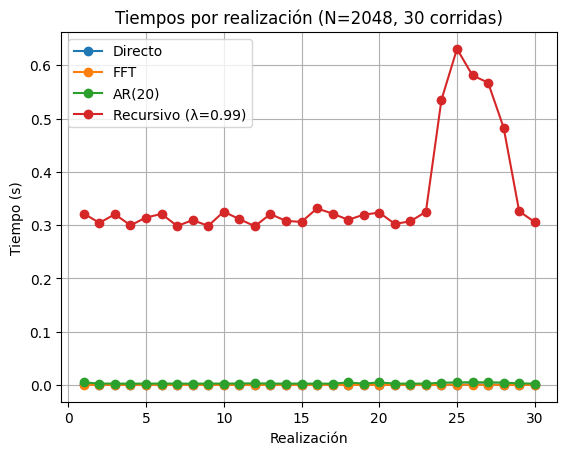


===== Resultados para N=2048 =====
         Directo:  E[t]=6.073591e-04 s   std=2.875497e-04 s
             FFT:  E[t]=4.202348e-04 s   std=9.283574e-05 s
          AR(20):  E[t]=3.419653e-03 s   std=9.940196e-04 s
Recursivo(λ=0.99):  E[t]=3.542944e-01 s   std=9.595162e-02 s


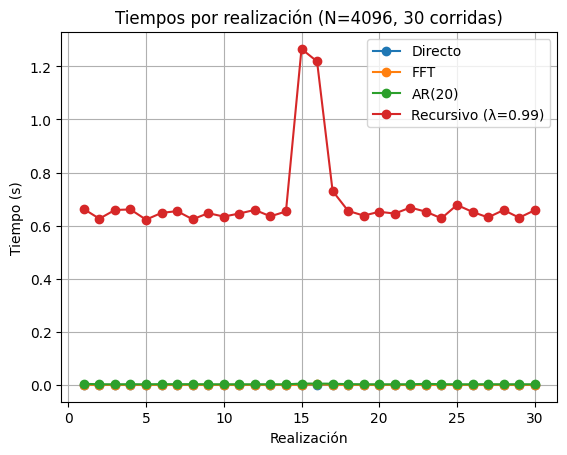


===== Resultados para N=4096 =====
         Directo:  E[t]=7.056173e-04 s   std=2.283398e-04 s
             FFT:  E[t]=7.802350e-04 s   std=3.652576e-04 s
          AR(20):  E[t]=3.311876e-03 s   std=8.710020e-04 s
Recursivo(λ=0.99):  E[t]=6.899988e-01 s   std=1.515881e-01 s


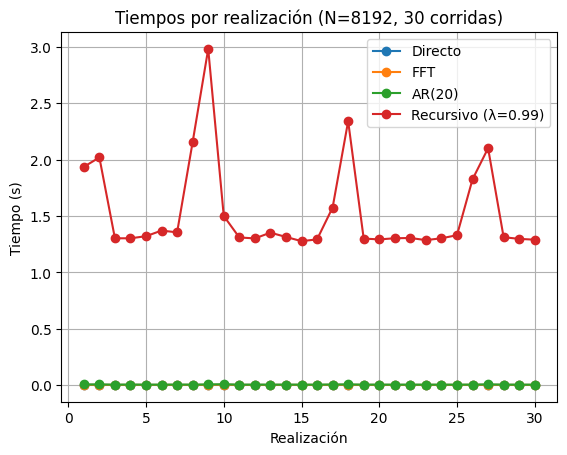


===== Resultados para N=8192 =====
         Directo:  E[t]=9.023430e-04 s   std=2.254664e-04 s
             FFT:  E[t]=1.341835e-03 s   std=2.476109e-04 s
          AR(20):  E[t]=3.558523e-03 s   std=9.658071e-04 s
Recursivo(λ=0.99):  E[t]=1.531450e+00 s   std=4.156423e-01 s


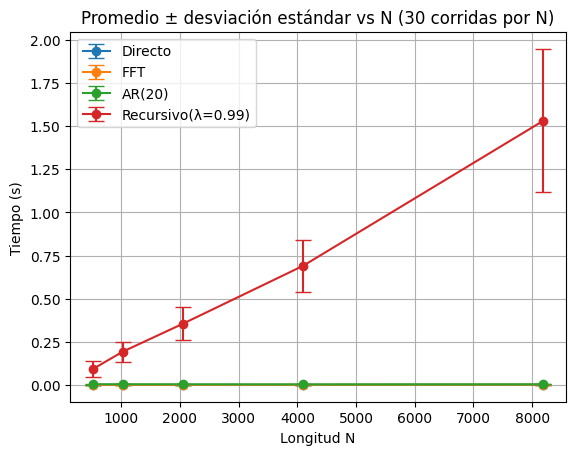

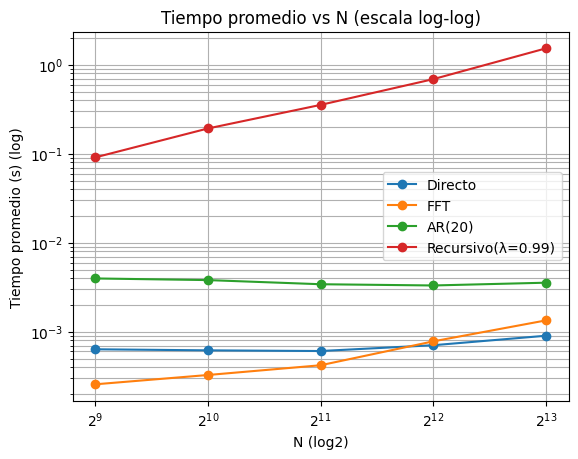

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time

# =========================
# CONFIGURACIÓN
# =========================
Ns = [512, 1024, 2048, 4096, 8192]  # <-- Pon aquí las longitudes que te pidan
L = 200
sigma = 1.0
runs = 30

# Parámetros de métodos
p = 20
lam = 0.99

# =========================
# CONTENEDORES DE RESULTADOS
# =========================
# Guardan: tiempos[N][método] = array de 30 tiempos
tiempos = {}

# Para guardar estadísticas finales por N
stats_mean = { "Directo": [], "FFT": [], f"AR({p})": [], f"Recursivo(λ={lam})": [] }
stats_std  = { "Directo": [], "FFT": [], f"AR({p})": [], f"Recursivo(λ={lam})": [] }

# =========================
# LOOP PRINCIPAL: por cada N
# =========================
for N in Ns:
    t_direct = np.zeros(runs)
    t_fft    = np.zeros(runs)
    t_ar     = np.zeros(runs)
    t_rec    = np.zeros(runs)

    for r in range(runs):
        # Señal distinta en cada realización
        rng = np.random.default_rng(12345 + r)
        x = sigma * rng.standard_normal(N)

        # -----------------------------
        # 1) DIRECTO (biased)
        # -----------------------------
        t0 = time.perf_counter()
        S = np.empty(L + 1, dtype=float)
        for k in range(L + 1):
            S[k] = np.dot(x[:N - k], x[k:])
        R_b_pos = S / N
        t1 = time.perf_counter()
        t_direct[r] = t1 - t0

        # -----------------------------
        # 2) FFT-based (biased)
        # -----------------------------
        t0 = time.perf_counter()
        M = 1 << int(np.ceil(np.log2(2 * N)))
        x_pad = np.zeros(M, dtype=float)
        x_pad[:N] = x
        X = np.fft.fft(x_pad)
        r_circ = np.fft.ifft(np.abs(X)**2).real
        S_fft = r_circ[:L + 1]
        R_fft_b_pos = S_fft / N
        t1 = time.perf_counter()
        t_fft[r] = t1 - t0

        # -----------------------------
        # 3) Paramétrico AR(p)
        # -----------------------------
        t0 = time.perf_counter()
        R0_to_p = np.empty(p + 1, dtype=float)
        for k in range(p + 1):
            R0_to_p[k] = np.dot(x[:N - k], x[k:]) / N

        T = np.empty((p, p), dtype=float)
        for i in range(p):
            for j in range(p):
                T[i, j] = R0_to_p[abs(i - j)]

        r_vec = R0_to_p[1:p+1].copy()
        a, *_ = np.linalg.lstsq(T, r_vec, rcond=None)

        # ACF paramétrica hasta L
        R_ar_pos = np.zeros(L + 1, dtype=float)
        R_ar_pos[0] = R0_to_p[0]
        for k in range(1, L + 1):
            acc = 0.0
            for i in range(1, p + 1):
                idx = k - i
                if idx >= 0:
                    acc += a[i - 1] * R_ar_pos[idx]
                else:
                    acc += a[i - 1] * R_ar_pos[-idx]
            R_ar_pos[k] = acc

        t1 = time.perf_counter()
        t_ar[r] = t1 - t0

        # -----------------------------
        # 4) Recursivo EWMA
        # -----------------------------
        t0 = time.perf_counter()
        R_rec_pos = np.zeros(L + 1, dtype=float)
        for n in range(N):
            xn = x[n]
            R_rec_pos[0] = lam * R_rec_pos[0] + (1 - lam) * (xn * xn)
            kmax = min(L, n)
            for k in range(1, kmax + 1):
                R_rec_pos[k] = lam * R_rec_pos[k] + (1 - lam) * (xn * x[n - k])
        t1 = time.perf_counter()
        t_rec[r] = t1 - t0

    # Guardar tiempos crudos por N
    tiempos[N] = {
        "Directo": t_direct,
        "FFT": t_fft,
        f"AR({p})": t_ar,
        f"Recursivo(λ={lam})": t_rec
    }

    # Calcular estadísticas por N (media y std muestral)
    for metodo in tiempos[N]:
        arr = tiempos[N][metodo]
        stats_mean[metodo].append(arr.mean())
        stats_std[metodo].append(arr.std(ddof=1))

    # =========================
    # GRÁFICA 1: tiempos por realización para este N
    # =========================
    realizaciones = np.arange(1, runs + 1)
    plt.figure()
    plt.plot(realizaciones, t_direct, marker='o', label="Directo")
    plt.plot(realizaciones, t_fft,    marker='o', label="FFT")
    plt.plot(realizaciones, t_ar,     marker='o', label=f"AR({p})")
    plt.plot(realizaciones, t_rec,    marker='o', label=f"Recursivo (λ={lam})")
    plt.title(f"Tiempos por realización (N={N}, {runs} corridas)")
    plt.xlabel("Realización")
    plt.ylabel("Tiempo (s)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Imprimir resumen por N
    print(f"\n===== Resultados para N={N} =====")
    for metodo in tiempos[N]:
        mu = tiempos[N][metodo].mean()
        sd = tiempos[N][metodo].std(ddof=1)
        print(f"{metodo:>16}:  E[t]={mu:.6e} s   std={sd:.6e} s")

# =========================
# GRÁFICA 2: promedio ± std vs N (comparando métodos)
# =========================
plt.figure()
for metodo in stats_mean:
    means = np.array(stats_mean[metodo])
    stds  = np.array(stats_std[metodo])
    plt.errorbar(Ns, means, yerr=stds, marker='o', capsize=6, label=metodo)

plt.title(f"Promedio ± desviación estándar vs N ({runs} corridas por N)")
plt.xlabel("Longitud N")
plt.ylabel("Tiempo (s)")
plt.grid(True)
plt.legend()
plt.show()

# (Opcional) Si quieres ver mejor tendencias tipo O(N log N):
plt.figure()
for metodo in stats_mean:
    means = np.array(stats_mean[metodo])
    plt.plot(Ns, means, marker='o', label=metodo)
plt.xscale("log", base=2)
plt.yscale("log")
plt.title("Tiempo promedio vs N (escala log-log)")
plt.xlabel("N (log2)")
plt.ylabel("Tiempo promedio (s) (log)")
plt.grid(True, which="both")
plt.legend()
plt.show()